In [1]:
#### IMPORTING LIBRARIES ####
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile 
from scipy.signal import chirp, spectrogram, find_peaks
from scipy import interpolate
from scipy.optimize import minimize
import IPython
from playsound import playsound 
import simpleaudio as sa
  

In [2]:
#### GENERATING THE SINE SWEEP ####
w1 = 1
w2 = 1
fs = 44100
T = 1
t = np.linspace(0,T,T*fs)
sweep = np.sin((w1*T/np.log(w2/w1))*(np.exp((t/T)*np.log(w2/w1)) - 1))
audio = sweep * (2**15 - 1) / np.max(np.abs(sweep))
audio = audio.astype(np.int16)

c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
c:\users\salma\documents\manuel\universidad\master\segundoaño\segundo\project course\calibration\project-course\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


## These next 2 cells are just for creating the wav file.

In [3]:
#fs, audio = wavfile.read("examples_input_samples_cmu_arctic_us_axb_a0006.wav")

In [3]:
#play_obj = sa.play_buffer(audio, 1, 2, fs)
#play_obj.wait_done()
#wavfile.write('sweep3266641.wav', fs, audio)
#playsound('sweep3266641.wav')

(0.0, 4.0)

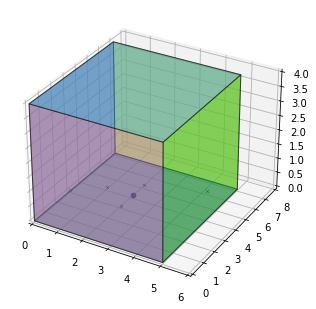

In [29]:
#### DESIGNING THE ROOM ####
fs = 96000*4;
c = 343;
pol = np.array([[0,0], [0,7], [5,7], [5,0]]).T
room = pra.Room.from_corners(pol, fs = fs, max_order=0, absorption=1, ray_tracing = False, air_absorption = False)
room.extrude(4)
# Adding the source
nSources = 1;
Xsource = np.array([3])
Ysource = np.array([2])
Zsource = np.array([1])

room.add_source(np.array([Xsource[0],Ysource[0],Zsource[0]]))
#room.add_source(np.array([Xsource[1],Ysource[1],Zsource[1]]), signal= 'sweep3266641.wav')

# Adding the microphone
Xmics = [3,5,2,1,3]
Ymics =[3,4,2,1,1]
Zmics = [1,1,1,1,1]
R = np.array([Xmics,Ymics,Zmics])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([0,6])
ax.set_ylim([0,8])
ax.set_zlim([0,4])

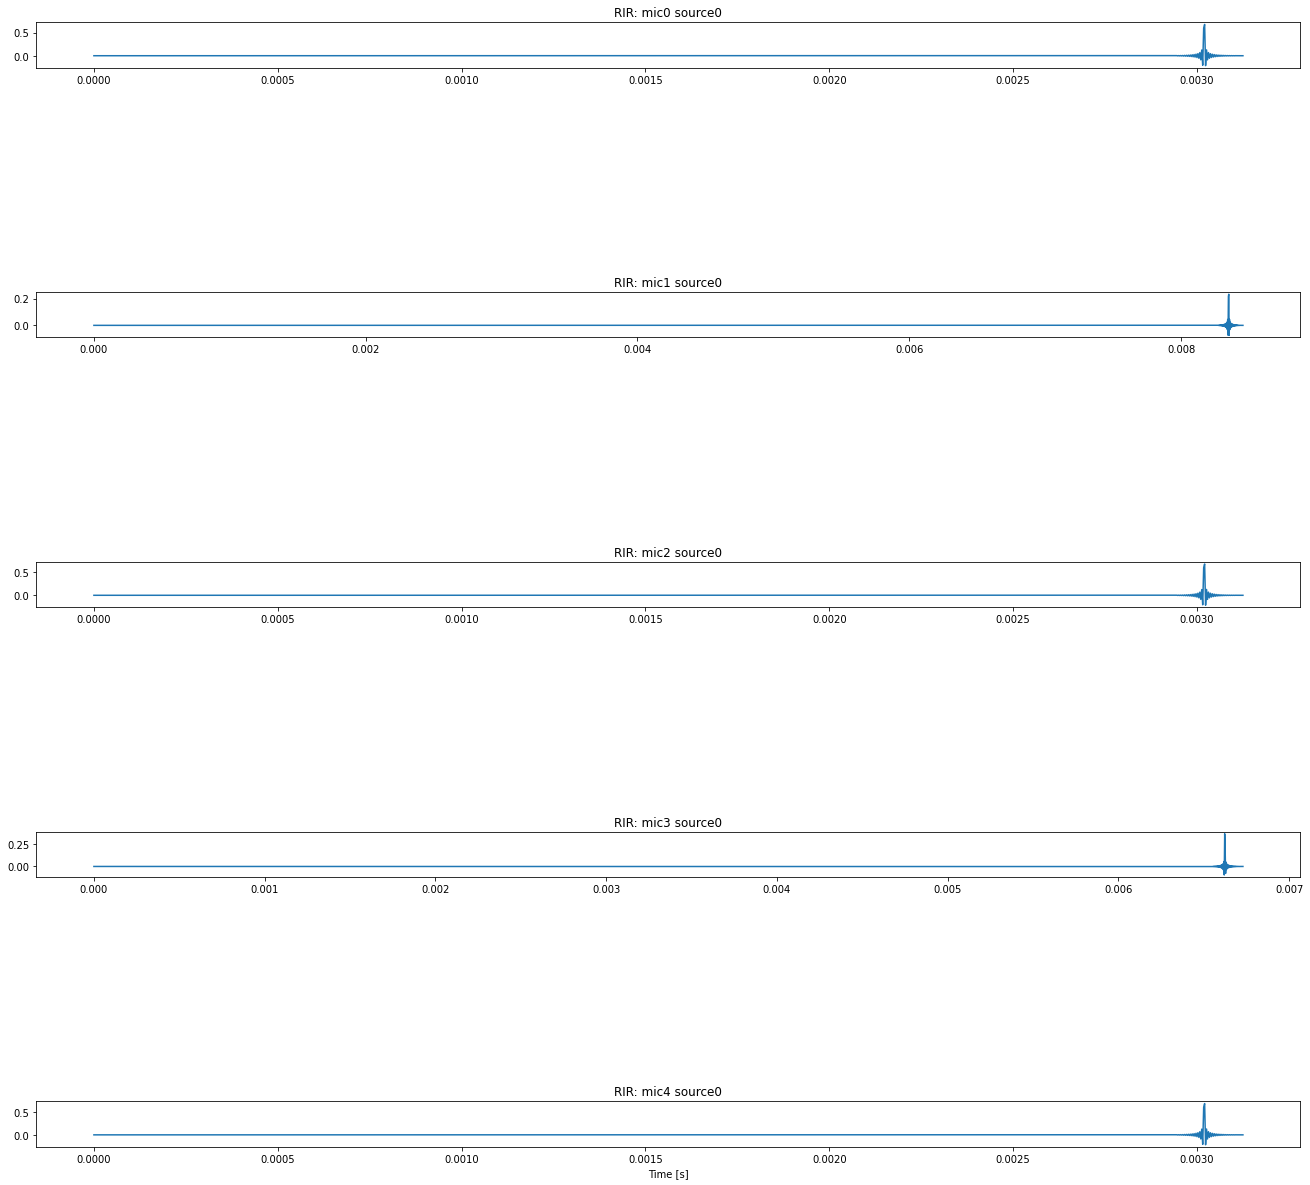

In [30]:
#### COMPUTING RIR ####
RIR = room.compute_rir()
# Plot and apply the RIR on the audio file
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20.5, 20.5)
RIRR = plt.show()

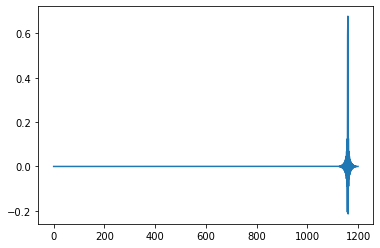

In [32]:
plt.figure();
plt.plot(room.rir[0][0])

In [36]:
def find_directPath(this_rir, top_peaks=15):
    this_rir = np.abs(this_rir)
    peaks, _ = find_peaks(this_rir)
    nHighest = (this_rir[peaks]).argsort()[::-1][:top_peaks]
    dp = np.sort((peaks[nHighest]))[:1]
    return dp

In [37]:
toa = np.zeros(shape=(len(Xmics)))
interp_factor = 10
do_interpolation = True
for m in range(0,len(Xmics)):
    if do_interpolation:
        this_rir = room.rir[m][0]
        sample_ax = np.arange(0, this_rir.shape[0])
        f = interpolate.interp1d(sample_ax, this_rir, kind='quadratic')
        sample_ax_new = np.arange(0, this_rir.shape[0]-1, 1/interp_factor)
        dp = find_directPath(f(sample_ax_new))
    else:
        this_rir = room.rir[m][0]
        dp = find_directPath(this_rir)
    toa[m] = (dp/interp_factor)*(1/fs) * c
    
print(toa)
print(this_rir.shape)

[1.029      2.8574401  1.029      2.26522917 1.029     ]
(1201,)


In [46]:
dist = np.zeros(shape=(len(Xmics)))
for m in range(0,len(Xmics)):
    path = find_directPath(room.rir[m][0])
    print(path)
    dist[m] = path * c/fs;
    print(dist)
    


[1160]
[1.03614583 0.         0.         0.         0.        ]
[3207]
[1.03614583 2.86458594 0.         0.         0.        ]
[1160]
[1.03614583 2.86458594 1.03614583 0.         0.        ]
[2543]
[1.03614583 2.86458594 1.03614583 2.27148177 0.        ]
[1160]
[1.03614583 2.86458594 1.03614583 2.27148177 1.03614583]


In [45]:
#### COMPUTING TIME OF FIRST REFLECTION (1 SOURCE) ####
time = [0,0,0,0,0,0];
for m in range(0,len(Xmics)):
    for n in range(1,len(room.rir[m][0]) - 1):
        if ((room.rir[m][0][n - 1] < room.rir[m][0][n]) & (room.rir[m][0][n + 1] < room.rir[m][0][n]) & (room.rir[m][0][n] > np.mean(room.rir[m][0]))):
            time[m] = n/48000;
            break;
    print('Room Impulse Response Mic', m,' empieza en: ', time[m], 'segundos')
    print('Muestra numero:', n)


Room Impulse Response Mic 0  empieza en:  0.023479166666666666 segundos
Muestra numero: 1127
Room Impulse Response Mic 1  empieza en:  0.06608333333333333 segundos
Muestra numero: 3172
Room Impulse Response Mic 2  empieza en:  0.023479166666666666 segundos
Muestra numero: 1127
Room Impulse Response Mic 3  empieza en:  0.052270833333333336 segundos
Muestra numero: 2509
Room Impulse Response Mic 4  empieza en:  0.023479166666666666 segundos
Muestra numero: 1127


IndexError: index 2 is out of bounds for axis 0 with size 1

In [5]:
#### COMPUTING TIME OF FIRST REFLECTION (MORE THAN 1 SOURCE) ####
time = [[0,0,0,0],[0,0,0,0]];

for m in range(0,len(Xmics)):
    for t in range(0,nSources):
        for n in range(1,len(room.rir[m][0]) - 1):
            if ((room.rir[m][t][n - 1] < room.rir[m][t][n]) & (room.rir[m][t][n + 1] < room.rir[m][t][n]) & (room.rir[m][t][n] > np.mean(room.rir[m][t]))):
                time[t][m] = n/16000;
                #print('Room Impulse Response empieza en: ', time, 'segundos')
                #print('Muestra numero:', n)
                break;
        print('Room Impulse Response Mic', m,'Source', t, 'empieza en: ', time[t][m], 'segundos')
        print('Muestra numero:', n)

Room Impulse Response Mic 0 Source 0 empieza en:  0.004625 segundos
Muestra numero: 74
Room Impulse Response Mic 0 Source 1 empieza en:  0.006625 segundos
Muestra numero: 106
Room Impulse Response Mic 1 Source 0 empieza en:  0.0078125 segundos
Muestra numero: 125
Room Impulse Response Mic 1 Source 1 empieza en:  0.012625 segundos
Muestra numero: 202
Room Impulse Response Mic 2 Source 0 empieza en:  0.014125 segundos
Muestra numero: 226
Room Impulse Response Mic 2 Source 1 empieza en:  0.0080625 segundos
Muestra numero: 129
Room Impulse Response Mic 3 Source 0 empieza en:  0.012875 segundos
Muestra numero: 206
Room Impulse Response Mic 3 Source 1 empieza en:  0.006625 segundos
Muestra numero: 106


In [51]:
#### COMPUTING DISTANCE BETWEEN MIC AND SOURCE ####

Xmics_ = np.asarray(Xmics)
Ymics_ = np.asarray(Ymics)
Zmics_ = np.asarray(Zmics)
delta = 0.0025 #Delay (2 ms)
distance_real = []
distance = []
for i in range(0, len(Xmics)):
    distance_real.append(np.sqrt(abs(Xsource - Xmics_[i])**2 + abs(Ysource - Ymics_[i])**2));
    distance.append(time[i]*c);
    
    print('Real distance between mic', i,'and source:', distance_real[i], 'metros');
    print('Distance according to RIR of mic',i,':', dist[i], 'metros')
    print('Delay of mic',i,':', (abs(distance_real[i] -  dist[i]))*1000/c, 'miliseconds \n')

Real distance between mic 0 and source: [1.] metros
Distance according to RIR of mic 0 : 1.0361458333333333 metros
Delay of mic 0 : [0.10538144] miliseconds 

Real distance between mic 1 and source: [2.82842712] metros
Distance according to RIR of mic 1 : 2.8645859375 metros
Delay of mic 1 : [0.10541928] miliseconds 

Real distance between mic 2 and source: [1.] metros
Distance according to RIR of mic 2 : 1.0361458333333333 metros
Delay of mic 2 : [0.10538144] miliseconds 

Real distance between mic 3 and source: [2.23606798] metros
Distance according to RIR of mic 3 : 2.2714817708333332 metros
Delay of mic 3 : [0.10324721] miliseconds 

Real distance between mic 4 and source: [1.] metros
Distance according to RIR of mic 4 : 1.0361458333333333 metros
Delay of mic 4 : [0.10538144] miliseconds 



In [6]:
##OPTIMIZATION PROBLEM USING THE REAL DISTANCE. THE DELAY IS NOT TAKEN INTO ACCOUNT
def fun2(x1):
  
    P = [0,0,0,0,0,0];
    D = [0,0,0,0,0,0];
    
    for i in range(0, len(Xmics)):
        P[i] = (np.sqrt(abs(x1[0] - Xmics_[i])**2 + abs(x1[1] - Ymics_[i])**2))
        D[i] = (np.sqrt(abs(sum(Xsource) - Xmics_[i])**2 + abs(sum(Ysource) - Ymics_[i])**2)) 
    P = np.array(P).T
    D = np.array(D).T
    return sum((P - D)**2);
bndsM = ((0,5),(0,4))
resM = minimize(fun2, (2.5,2), method='SLSQP', bounds=bndsM)
print(resM.x)

[3.00000474 4.        ]


In [54]:
##OPTIMIZATION PROBLEM USING DELAY.
def fun2(x1):
  
    P = [0,0,0,0];
    D = [0,0,0,0];
    #D1 = [0,0,0,0];
    T = [x1[2]*c,x1[2]*c,x1[2]*c,x1[2]*c];
    for i in range(0, 4):
        P[i] = (np.sqrt(abs(x1[0] - Xmics_[i])**2 + abs(x1[1] - Ymics_[i])**2))
        #D[i] = (np.sqrt(abs(sum(Xsource) - Xmics_[i])**2 + abs(sum(Ysource) - Ymics_[i])**2))
        D[i] = dist[i];   
    P = np.array(P).T
    D = np.array(D).T
    return sum((P - (D - T))**2);
bndsM = ((0,5),(0,4),(0,0.5))
resM = minimize(fun2, (2,2,0), method='SLSQP', bounds=bndsM)
print(resM.x)

[3.00038777e+00 1.99909355e+00 1.03940876e-04]
